# Basic Dataset Starter

This notebook contains very basic starter code for loading the real vs fake faces dataset from file and working with it. You can borrow from this to:
- start training new models (for the transfer learning and custom architecture subteams)
- analyze and look into the dataset plus implement data augmentation

## Download the data from Kaggle

In [1]:
!rm -rf real_and_fake_face real_and_fake_face_detection processed

In [1]:
from google.colab import drive
from subprocess import Popen, PIPE
# makes files from your drive accessible
drive.mount('/content/drive', force_remount=True)

# TODO - specify path to your API key via google drive
#api_key_filepath = "/content/drive/MyDrive/ColabNotebooks/kaggle.json"
api_key_filepath = "/content/drive/MyDrive/MDST/RvF/kaggle.json"

# Kaggle API Key setup ------------------
cmd = "mkdir /root/.kaggle"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"cp -f {api_key_filepath} /root/.kaggle/"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"chmod 600 /root/.kaggle/kaggle.json"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
# ------------------------------
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip -q real-and-fake-face-detection.zip
!mkdir plots

Mounted at /content/drive
 
 
 
 95% 409M/431M [00:04<00:00, 114MB/s]
100% 431M/431M [00:04<00:00, 99.4MB/s]


# Setup PyTorch Data Loading

The code in the next cell can be copied into your notebook to load the downloaded data correctly. It does two things:
- processes the dataset into a train and test set
- creates data loaders for the training and testing data

Don't worry about the details, but if you're on the dataset team, you'll want to read carefully through this part to understand how the code works (since you'll be editing this to make your own version of the dataset!)

In [64]:
from imageio.v3 import imread
import pandas as pd
from pathlib import Path
from random import random
from shutil import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional
!pip -q install grad-cam
from matplotlib import pyplot as plt
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as tf
from typing import Callable
from torch import nn
from torch.utils.data import DataLoader

class RealAndFakeFaceProcessor:
    def __init__(self, directory, train_test_split = 0.7) -> None:
        self.train_test_split = train_test_split

        self.train_index = 0
        self.test_index = 0

        self.src_directory = Path(directory)
        self.directory = self.src_directory.parent / "processed"

        self.tgt_train = self.directory / "train"
        self.tgt_train.mkdir(parents=True, exist_ok=True)

        self.tgt_test = self.directory / "test"
        self.tgt_test.mkdir(parents=True, exist_ok=True)

        self.index_by_type = {"index":[], "partition": [], "type": [], "label": [], "filename": []}
        self.__process("training_fake","easy")
        self.__process("training_fake","mid")
        self.__process("training_fake","hard")
        self.__process("training_real","real")

        df = pd.DataFrame(self.index_by_type)
        df.to_csv(self.directory / "images.csv", index=False)


    def __add_image_to_record(self, index: int, partition: str, type: str, label: int, filename: str):
        """Real - label is 1, Fake - label is 0"""
        self.index_by_type["index"].append(index)
        self.index_by_type["partition"].append(partition)
        self.index_by_type["type"].append(type)
        self.index_by_type["label"].append(label)
        self.index_by_type["filename"].append(filename)


    def __process(self, subdir: str, type: str) -> None:
        src = self.src_directory / subdir
        label = 1 if type == "real" else 0

        for image in src.iterdir():
            if image.name.startswith(type):
                random_number = random()
                if random() > self.train_test_split:
                    copy(image.absolute(), self.tgt_test / f"{self.test_index}.png")
                    self.__add_image_to_record(self.test_index, "test", type, label, image.name)
                    self.test_index += 1
                else:
                    copy(image.absolute(), self.tgt_train / f"{self.train_index}.png")
                    self.__add_image_to_record(self.train_index, "train", type, label, image.name)
                    self.train_index += 1

class RealAndFakeFaceDataset(Dataset):
    def __init__(
        self,
        directory: str,
        partition: str ="train"
    ) -> 'RealAndFakeFaceDataset':
        self.partition = partition
        if partition not in ("train", "test"):
            raise ValueError(f"Invalid partition specified - {partition}")
        self.directory = Path(directory)
        self.img_directory = self.directory / partition
        metadata = pd.read_csv(self.directory / "images.csv")
        self.metadata = metadata[metadata["partition"] == self.partition]

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, index: int) -> tuple[torch.tensor, int]:
        filename = self.img_directory / f"{index}.png"
        label = self.metadata.iloc[index]["label"]

        image = torch.from_numpy(imread(filename))
        image = image.to(torch.float32)
        image = image.permute((2,0,1))
        image = functional.resize(image, (224, 224), antialias=True)
        image /= 255.0


        return image, label

    def get_type(self, index) -> str:
        return self.metadata.iloc[index]["type"]

    def get_filename(self, index) -> str:
        return self.metadata.iloc[index]["filename"]

processor = RealAndFakeFaceProcessor("real_and_fake_face") # Call this to process the dataset into a train and test set
train = RealAndFakeFaceDataset("processed", "train")
test = RealAndFakeFaceDataset("processed", "test")

train_loader = DataLoader(train, batch_size = 32, shuffle=True)
test_loader = DataLoader(test, batch_size = 32)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = "same")
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same")
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = "same")
        self.conv4 = torch.nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = "same")
        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = "same")
        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = "same")
        self.dense1_v2 = torch.nn.Linear(2304, 768)
        self.dense2_v2 = torch.nn.Linear(768, 384)
        self.dense3_v2 = torch.nn.Linear(384, 2)
        self.norm_layer1 = torch.nn.BatchNorm2d(32)
        self.norm_layer2 = torch.nn.BatchNorm2d(64)
        self.norm_layer3 = torch.nn.BatchNorm2d(128)
        self.norm_layer4 = torch.nn.BatchNorm2d(128)
        self.norm_layer5 = torch.nn.BatchNorm2d(256)
        self.norm_layer6 = torch.nn.BatchNorm2d(256)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.activation = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.init_weight()
    def init_weight(self):
        conv = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]
        dense = [self.dense1_v2, self.dense2_v2, self.dense3_v2]
        for layer in conv:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)
        for layer in dense:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)
    def forward(self, x):
        x = self.pool(self.activation(self.norm_layer1(self.conv1(x))))
        x = self.pool(self.activation(self.norm_layer2(self.conv2(x))))
        x = self.pool(self.activation(self.norm_layer3(self.conv3(x))))
        x = self.pool(self.activation(self.norm_layer4(self.conv4(x))))
        x = self.pool(self.activation(self.norm_layer5(self.conv5(x))))
        x = self.dropout1(x)
        x = self.pool(self.activation(self.norm_layer6(self.conv6(x))))
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.activation(self.dense1_v2(x))
        x = self.activation(self.dense2_v2(x))
        return self.dense3_v2(x)

# Instantiate Model:

In [66]:
device ='cuda' if torch.cuda.is_available() else 'cpu' # automatically use gpu if available
model = Net().to(device)
#model.load_state_dict(torch.load("/content/epoch=8-checkpoint.pth"), strict = False)
#model.load_state_dict(torch.load("/content/drive/MyDrive/MDST/RvF/weights_V1.pth"), strict = False)
#model.load_state_dict(torch.load("/content/drive/MyDrive/MDST/RvF/weights_V2.pth"), strict = False)
#model.load_state_dict(torch.load("/content/drive/MyDrive/MDST/RvF/weights_V3.pth"), strict = False)
model.load_state_dict(torch.load("/content/drive/MyDrive/MDST/RvF/weights_V4.pth"), strict = False)  # Latest weights

for name, parameter in model.named_parameters():
    if (name[0:4] == "conv"):
      parameter.requires_grad = False

# Train Model:

In [ ]:
def evaluate(model: nn.Module, criterion: Callable, loader: DataLoader, device='cuda') -> tuple[float]:
    with torch.no_grad():
        correct, total = 0,0
        loss = 0.0
        for i, (X, y) in enumerate(loader):
            outputs = model(X.to(device)).to('cpu')
            loss += criterion(outputs, y).item()
            _, predicted = torch.max(outputs.data, 1) # get predicted class
            total += len(y)
            correct += (predicted == y).sum().item()
    return correct / total, loss / total

device ='cuda' if torch.cuda.is_available() else 'cpu' # automatically use gpu if available
epochs = 20  # Change Number of epochs
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
#model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

for epoch in range(epochs):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    train_accuracy, train_loss = evaluate(model, criterion, train_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_loss = evaluate(model, criterion, test_loader, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(
        f"Epoch {epoch + 1}: Loss - (Train {train_loss:.5f}/Test {test_loss:.2f}, "
        f"Accuracy - (Train {train_accuracy:.5f}/Test {test_accuracy:.2f})"
    )

100%|██████████| 46/46 [00:26<00:00,  1.74it/s]


Epoch 1: Loss - (Train 0.01907/Test 0.02, Accuracy - (Train 0.68367/Test 0.58)


100%|██████████| 46/46 [00:18<00:00,  2.42it/s]


Epoch 2: Loss - (Train 0.01704/Test 0.02, Accuracy - (Train 0.71950/Test 0.59)


100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 3: Loss - (Train 0.01650/Test 0.02, Accuracy - (Train 0.73260/Test 0.56)


100%|██████████| 46/46 [00:18<00:00,  2.51it/s]


Epoch 4: Loss - (Train 0.01897/Test 0.03, Accuracy - (Train 0.68711/Test 0.54)


100%|██████████| 46/46 [00:18<00:00,  2.48it/s]


Epoch 5: Loss - (Train 0.01401/Test 0.03, Accuracy - (Train 0.78360/Test 0.57)


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


Epoch 6: Loss - (Train 0.01312/Test 0.03, Accuracy - (Train 0.80358/Test 0.54)


100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 7: Loss - (Train 0.01153/Test 0.03, Accuracy - (Train 0.84287/Test 0.63)


100%|██████████| 46/46 [00:18<00:00,  2.44it/s]


Epoch 8: Loss - (Train 0.01143/Test 0.03, Accuracy - (Train 0.82977/Test 0.58)


100%|██████████| 46/46 [00:18<00:00,  2.45it/s]


Epoch 9: Loss - (Train 0.01049/Test 0.03, Accuracy - (Train 0.87181/Test 0.58)


100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 10: Loss - (Train 0.00912/Test 0.03, Accuracy - (Train 0.88353/Test 0.56)


100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 11: Loss - (Train 0.00966/Test 0.04, Accuracy - (Train 0.86561/Test 0.60)


100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 12: Loss - (Train 0.00613/Test 0.04, Accuracy - (Train 0.91730/Test 0.60)


100%|██████████| 46/46 [00:19<00:00,  2.41it/s]


Epoch 13: Loss - (Train 0.00746/Test 0.04, Accuracy - (Train 0.90214/Test 0.58)


100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 14: Loss - (Train 0.00577/Test 0.04, Accuracy - (Train 0.92833/Test 0.56)


100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 15: Loss - (Train 0.00552/Test 0.04, Accuracy - (Train 0.93660/Test 0.58)


100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 16: Loss - (Train 0.00415/Test 0.04, Accuracy - (Train 0.95038/Test 0.58)


100%|██████████| 46/46 [00:18<00:00,  2.55it/s]


Epoch 17: Loss - (Train 0.00380/Test 0.05, Accuracy - (Train 0.95451/Test 0.59)


100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 18: Loss - (Train 0.00378/Test 0.05, Accuracy - (Train 0.95451/Test 0.56)


100%|██████████| 46/46 [00:18<00:00,  2.44it/s]


Epoch 19: Loss - (Train 0.00435/Test 0.05, Accuracy - (Train 0.94900/Test 0.58)


100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 20: Loss - (Train 0.00296/Test 0.05, Accuracy - (Train 0.96761/Test 0.57)


# Interpret Transfer Model (Last Two Convolutional Layers)

<ipython-input-82-b36ad931d955>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2)


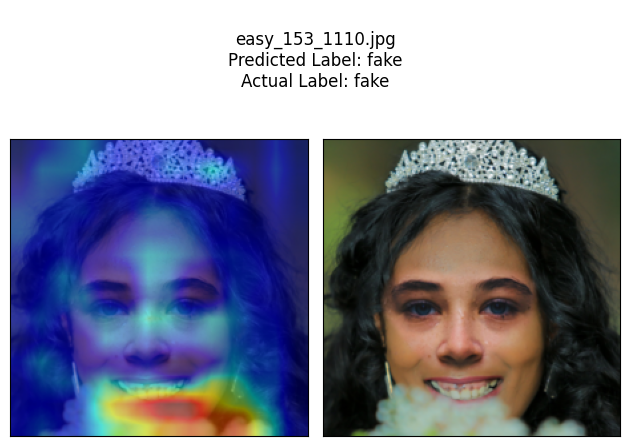

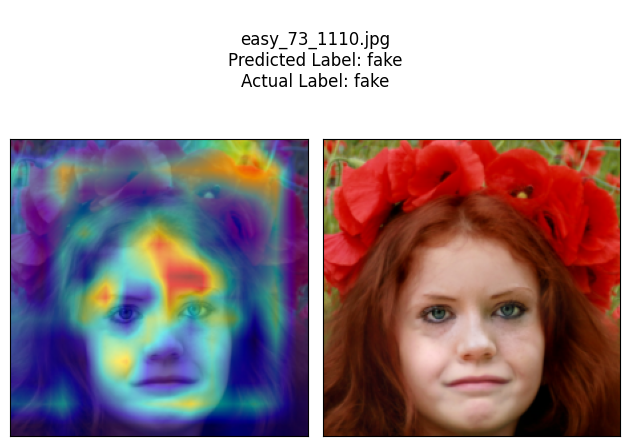

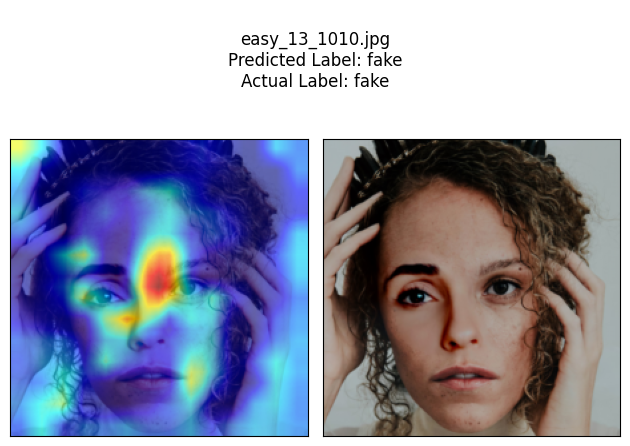

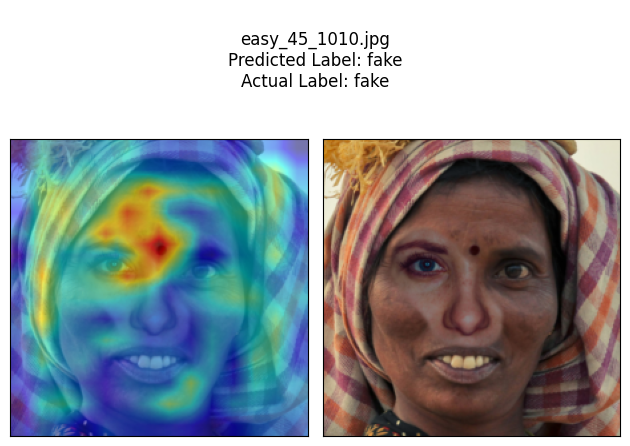

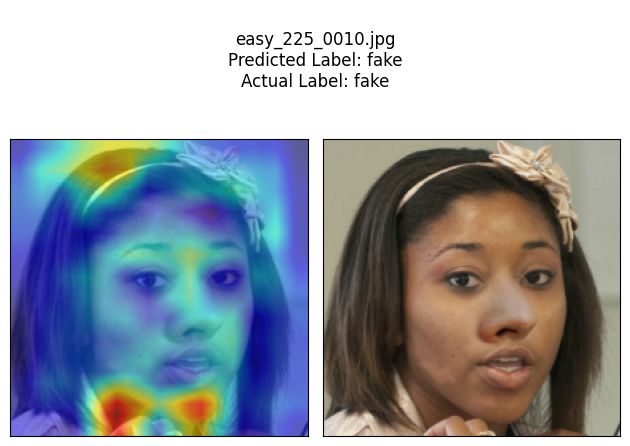

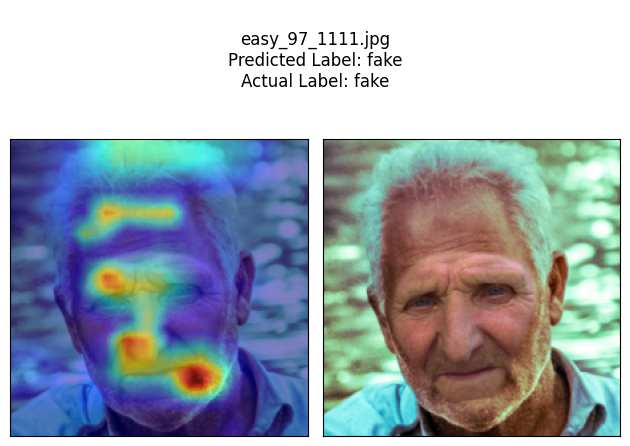

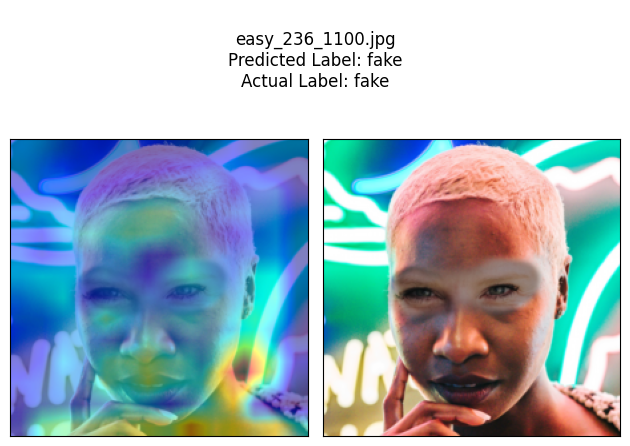

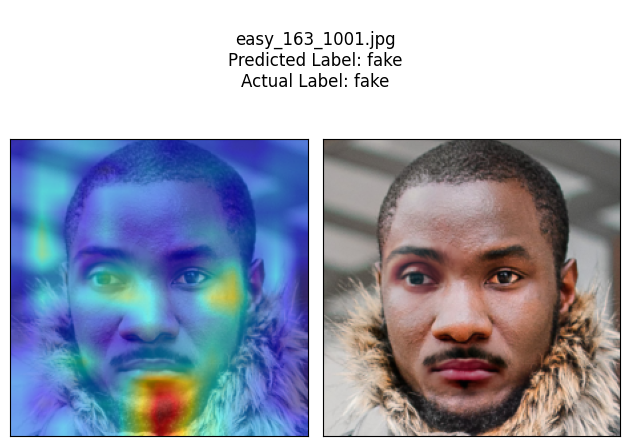

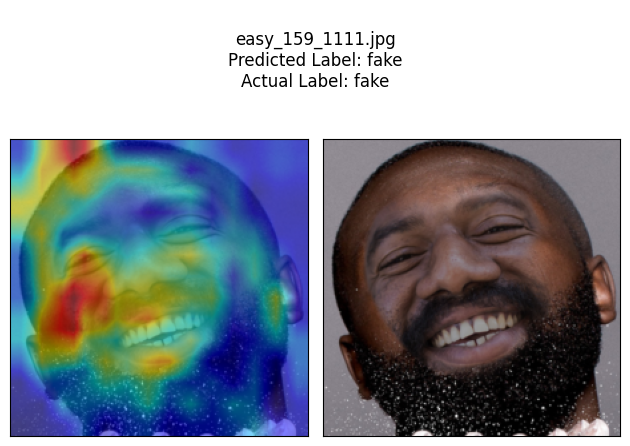

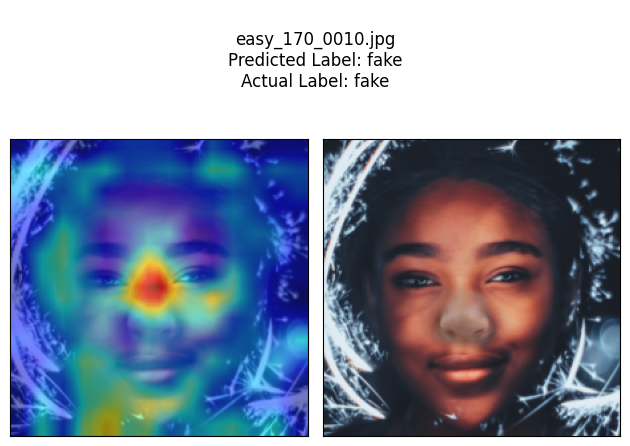

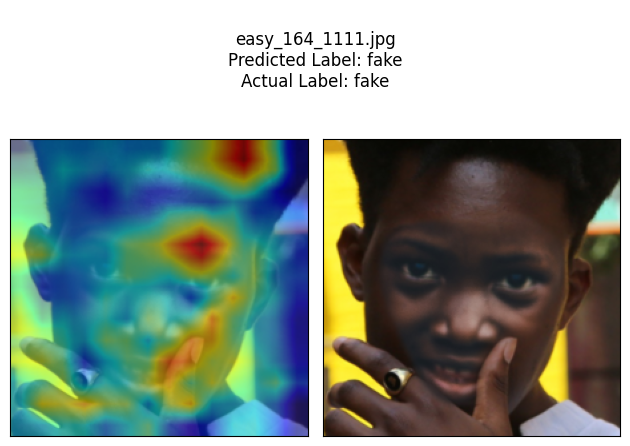

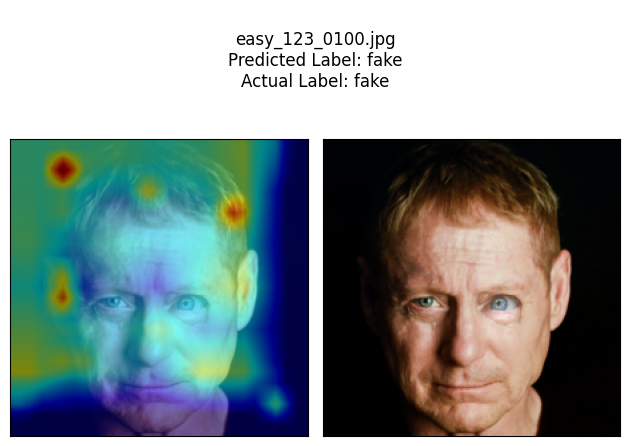

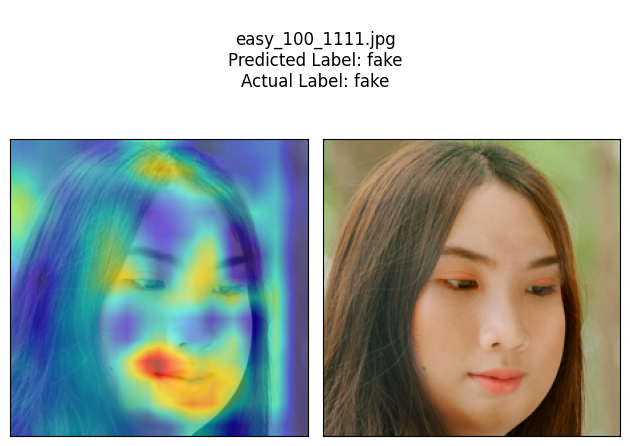

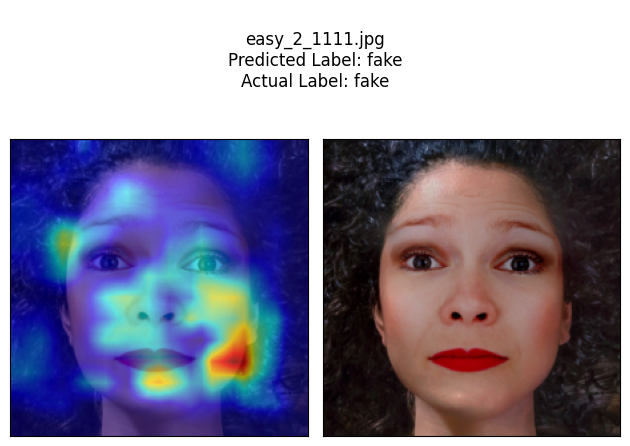

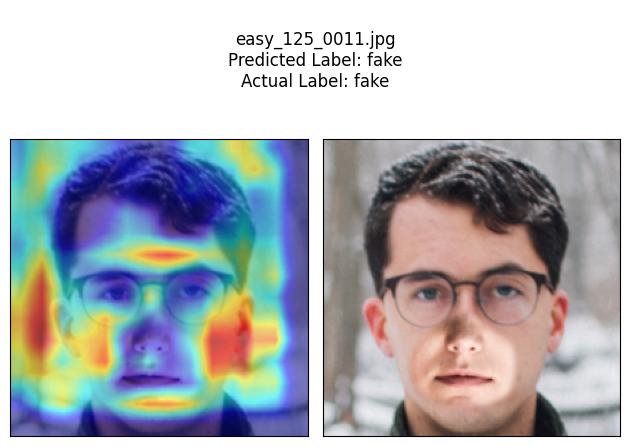

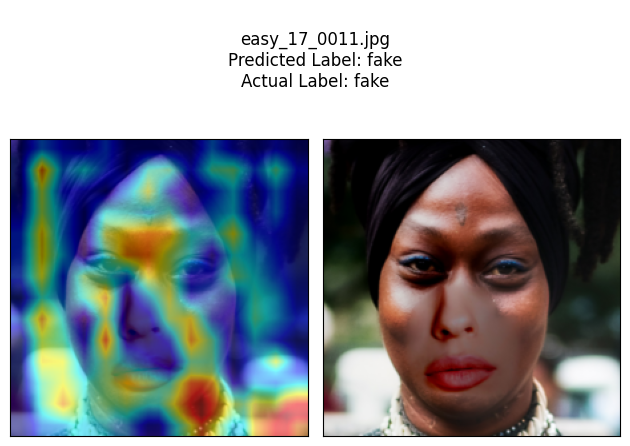

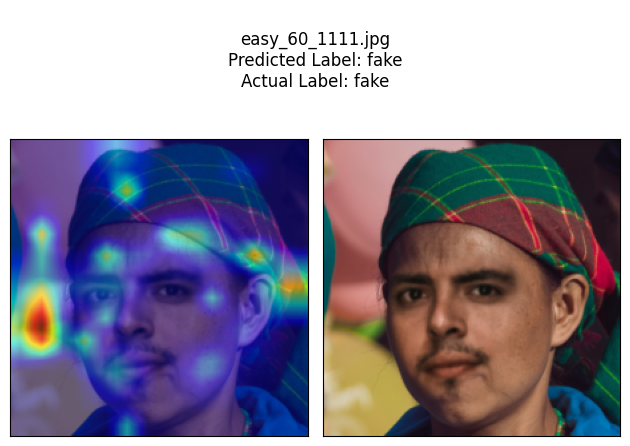

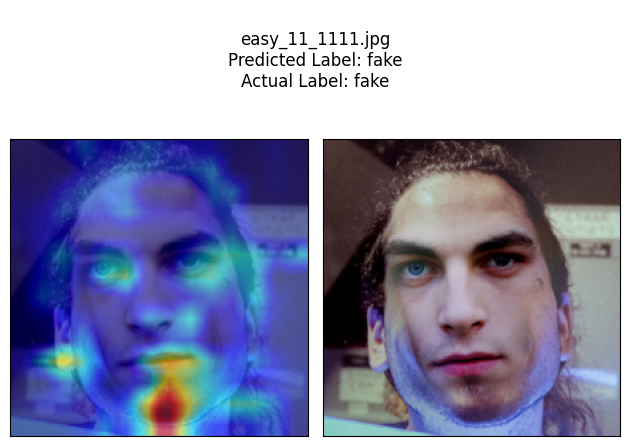

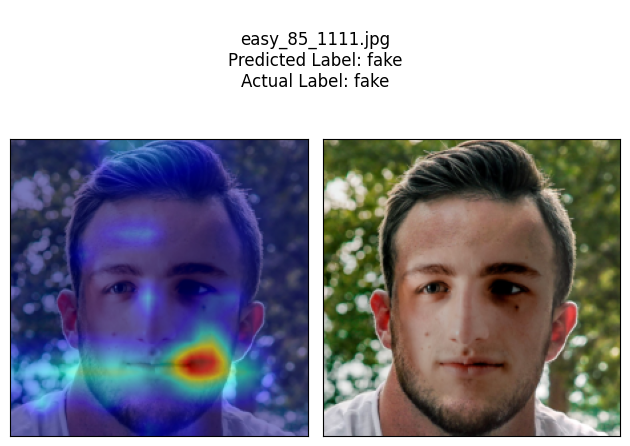

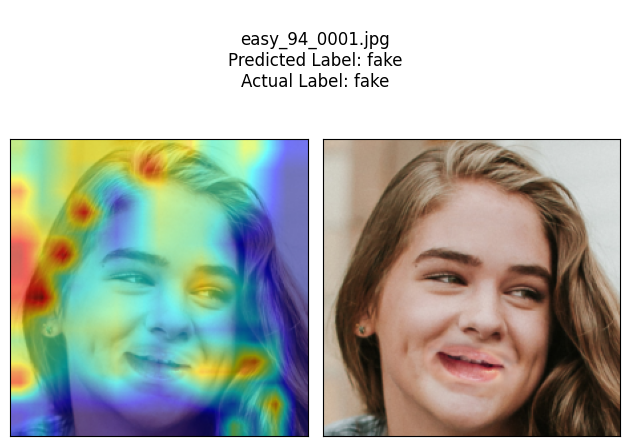

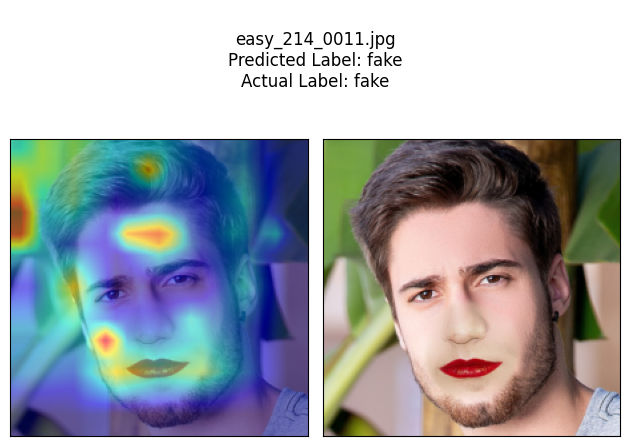

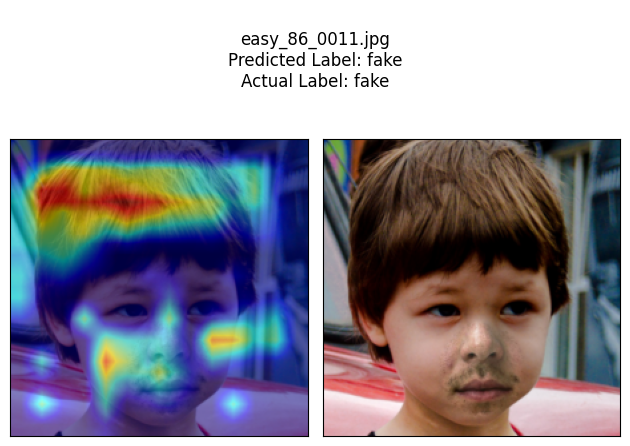

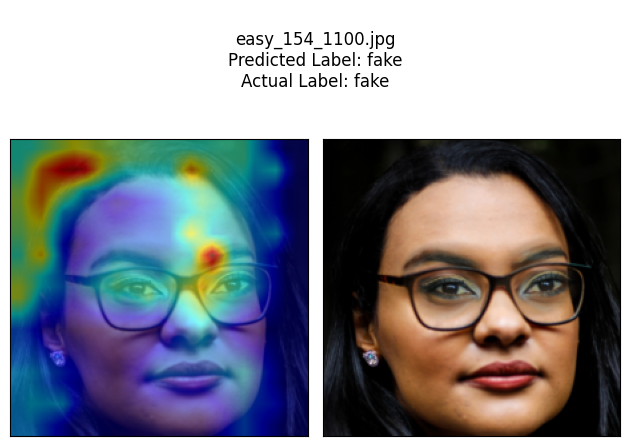

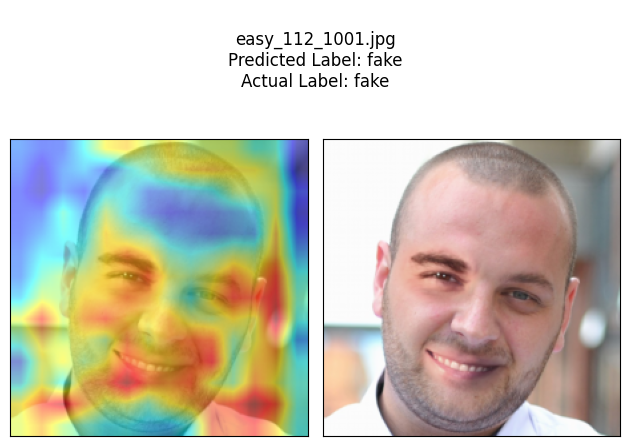

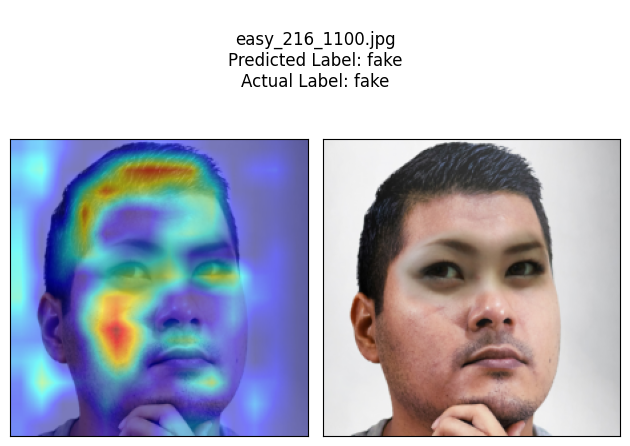

In [82]:

# getting the first image in the training set
#index = 0
#image, label = train[index]
#print(f"Image {index} in the training set has type {train.get_type(index)} and is {'fake' if label == 0 else 'real'}")
#plt.imshow(image.permute((1,2,0)))

for idx in range(25):
  ####################
  # select image here:
  ####################
  index = idx
  #X, y = train[len(train)-index-1]
  X, y = train[index]
  filename = train.get_filename(index)  # <- recently added function
  ####################

  #cam = GradCAM(model=model, target_layers=[model.conv4, model.conv5, model.conv6])
  cam = GradCAM(model=model, target_layers=[model.conv5, model.conv6])
  # 0 = figure out what parts of the image make the model think face is fake
  targets = [ClassifierOutputTarget(0)]
  pipeline = tf.Compose([
      #tf.ToTensor(),
      tf.ConvertImageDtype(torch.float32),
      tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      tf.Resize((224,224))
  ])
  input_tensor = pipeline(X).view(1,3,224,224)

  grayscale_cam = cam(input_tensor=input_tensor.to("cuda"), targets=targets)
  resized_image = cv2.resize(X.permute(1, 2, 0).numpy(), (224,224))
  visualization = show_cam_on_image((resized_image*255).astype('uint8')/255, grayscale_cam[0, :], use_rgb=True)

  with torch.no_grad():
    outputs = model(X.to(device).unsqueeze(0)).to('cpu')
  _, predicted = torch.max(outputs.data, 1) # get predicted class
  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.suptitle(f"\n{filename}\nPredicted Label: {'fake' if predicted == 0 else 'real'}\nActual Label: {'fake' if y == 0 else 'real'}")
  ax1.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)

  ax2.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)
  ax2.imshow(X.permute((1,2,0)))
  ax1.imshow(visualization)
  plt.tight_layout()
  #plt.show()
  plt.savefig(f"plots/{filename}")